In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

In [2]:
df = pd.read_csv('../data/Tweets.csv')

In [3]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


In [5]:
df_1 = df.drop(['airline_sentiment_gold', 'negativereason_gold', 
                'tweet_coord'], axis=1)

Looking we see that some columns have really low non-null object counts.  Columns airline_sentiment_gold has 40, negativereason_gold has 32, and twee_coord only has 1019.  These columns with a lot of missing values won't be of use in the model and will be dropped.  

In [6]:
df_1.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [7]:
df_1 = df_1.drop(['airline_sentiment_confidence', 'negativereason_confidence', 'retweet_count'], axis=1)

Looking at the quantative data we see that the max for retweet_count is 44.  That is too low to be useful for the model.  

The other quantative columns are tweet_id that is an unique key to each tweet.  The two other columns airline_sentiment_confidence and negativereason_confidence seem to be human confidence of rating the tweets.  They will not be helpful and will be dropped.

In [8]:
df_1['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

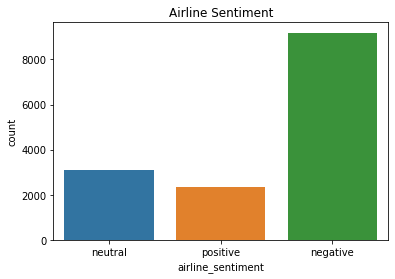

In [9]:
sns.countplot(df_1['airline_sentiment'])
plt.title('Airline Sentiment');

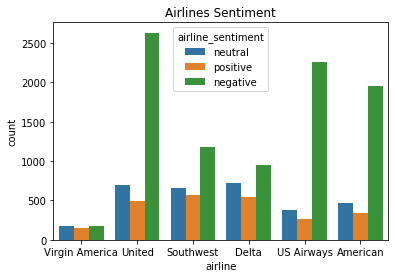

In [10]:
sns.countplot(df_1['airline'], hue=df_1['airline_sentiment'])
plt.title('Airlines Sentiment');

In [11]:
# create a dummie matrix of user_timezone
df_a = pd.get_dummies(df_1['airline'])
# add tweet_id to dummies matrix and merge with original dataframe
df_a['tweet_id'] = df_1['tweet_id']

df_1 = pd.merge(df_1, df_a, on='tweet_id')

In the graph above we see the airline sentiments of each airline neutral, positive, and negative counts.  We see that all but Virgin America have a lot more negative tweets then neutral or positive and in some cases more then both of them combined.

In [12]:
columns = ['negativereason', 'name', 'tweet_created', 
           'tweet_location', 'user_timezone']

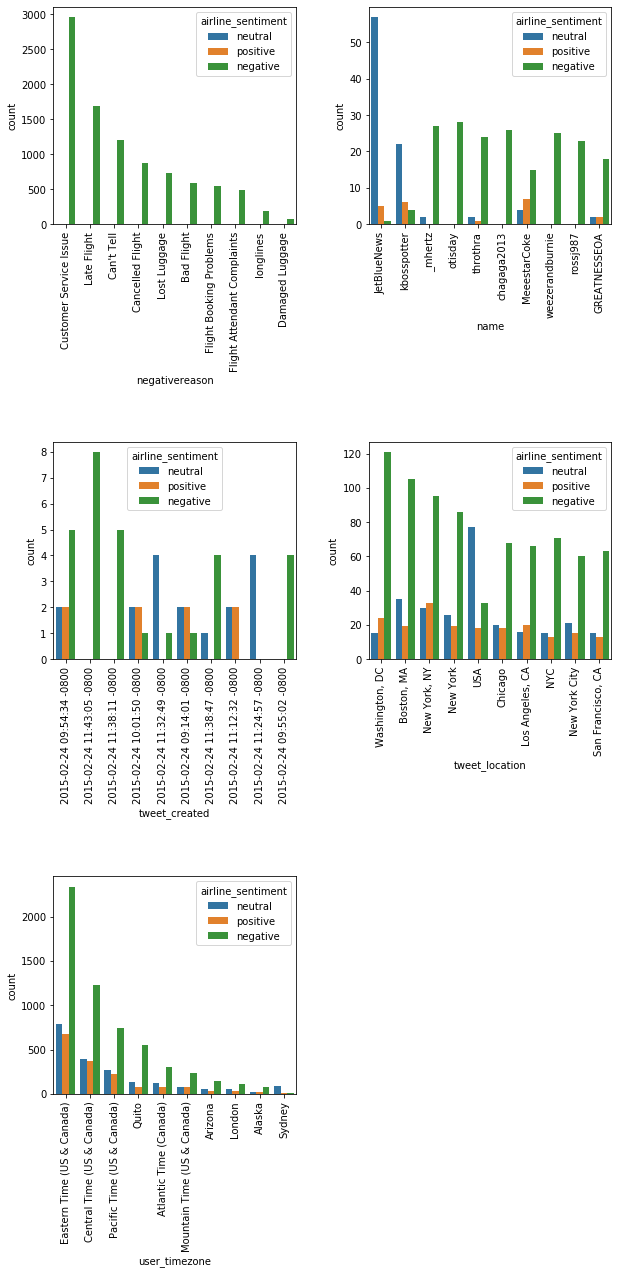

In [13]:
fig = plt.figure(figsize=(10, 20))
fig.subplots_adjust(hspace=1, wspace=0.3)

for i, c in enumerate(columns, start=1):
    ax = fig.add_subplot(3, 2, i)
    chart = sns.countplot(x=c, data=df_1, hue='airline_sentiment',
                          order=df_1[c].value_counts().iloc[:10].index)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

In [14]:
df_1 = df_1.drop(['negativereason', 'name'], axis=1)

The graphs above show us the top ten most frequent values in the categorical columns.  We see that columns name, tweet_created, tweet_location have very low counts.  But looking at tweet_created as a different type of date would probably bring the counts up.  We could do day of week, hour, or month date.

In [15]:
df_1['day'] = pd.DatetimeIndex(df_1['tweet_created']).dayofweek
df_1['hour'] = pd.DatetimeIndex(df_1['tweet_created']).hour
df_1['date'] = pd.DatetimeIndex(df_1['tweet_created']).date

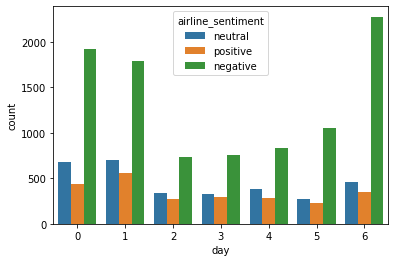

In [16]:
chart = sns.countplot(x='day', data=df_1, hue='airline_sentiment');

In [17]:
# Create list of the non top ten inthe user_timezone 
user_timezone_lowest = list(df_1['user_timezone'].value_counts().tail(842).index)
# create a dummie matrix of user_timezone
df_day = pd.get_dummies(df_1['day'])
df_day =df_day.rename(columns={0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})
# add tweet_id to dummies matrix and merge with original dataframe
df_day['tweet_id'] = df_1['tweet_id']

df_1 = pd.merge(df_1, df_day, on='tweet_id')

We see that most tweets were created on Monday, Tuesday, and Saturday.

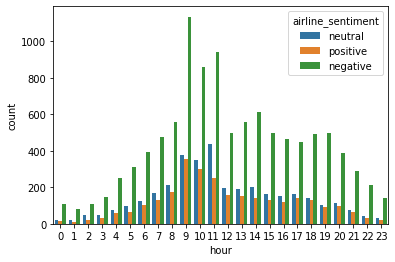

In [18]:
chart = sns.countplot(x='hour', data=df_1, hue='airline_sentiment');

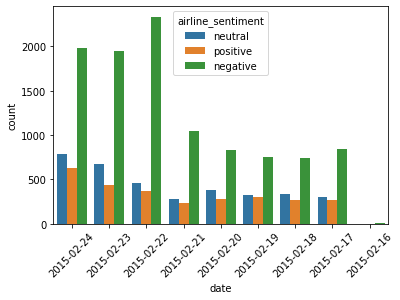

In [19]:
chart = sns.countplot(x='date', data=df_1, hue='airline_sentiment')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

We see that data was only collected over 8 days Between February 16 and 24 in 2015.

In [20]:
print('Rows where user_timezone is null but tweet_location has value: ', 
      df_1['tweet_location'][df_1['user_timezone'].isnull()].count())

Rows where user_timezone is null but tweet_location has value:  2401


In [21]:
df_1['tweet_location'][df_1['user_timezone'].isnull()].value_counts().head(10)

BK                                50
New York                          47
San Diego                         38
Belle MO                          37
Mexico City                       33
MiniApple(s)                      32
NY (Globetrotter.ExBonaerense)    32
San Francisco, CA                 29
Plano, Texas                      28
Boston, MA                        26
Name: tweet_location, dtype: int64

In [22]:
us_time = {'Alaska': ['AK', 'ALASKA'], 
           'Central Time (US & Canada)': ['AL', 'AR', 'IL', 'IA', 
                                          'KS', 'KY', 'LA', 'MN', 
                                          'MI', 'MO', 'NE', 'ND', 
                                          'OK', 'SD', 'TN', 'TX', 
                                          'WI', 'ALABAMA', 
                                          'ARKANSAS','ILLINOIS', 
                                          'IOWA', 'KANSAS', 
                                          'KENTUCKY', 'LOUISIANA', 
                                          'MINNESOTA', 'MISSISSIPPI',
                                          'MISSOURI', 'NEBRASKA', 
                                          'NORTH DAKOTA','OKLAHOMA',
                                          'SOUTH DAKOTA','TENNESSEE',
                                          'TEXAS', 'WISCONSIN'], 
           'Eastern Time (US & Canada)': ['CT', 'DE', 'DC', 'FL', 
                                          'GA', 'IN', 'ME', 'MD', 
                                          'MA', 'MI', 'NH', 'NJ', 
                                          'NY', 'NC', 'OH', 'PA', 
                                          'RI', 'SC', 'VT', 'VA', 
                                          'WV', 'CONNECTICUT', 
                                          'DELAWARE', 'FLORIDA', 
                                          'GEORGIA', 'INDIANA', 
                                          'MAINE', 'MARYLAND', 
                                          'MASSACHUSETTS', 
                                          'MICHIGAN','NEW HAMPSHIRE', 
                                          'NEW JERSEY', 'NEW YORK', 
                                          'NORTH CAROLINA', 'OHIO', 
                                          'PENNSYLVANIA', 
                                          'RHODE ISLAND', 
                                          'SOUTH CAROLINA', 
                                          'VERMONT', 'VIRGINIA', 
                                          'WEST VIRGINIA'], 
           'Mountain Time (US & Canada)': ['AZ', 'CO', 'ID', 'MT', 
                                           'NM', 'UT', 'WY', 
                                           'ARIZONA', 'COLORADO', 
                                           'IDAHO', 'MONTANA', 
                                           'NEW MEXICO', 'UTAH', 
                                           'WYOMING'], 
           'Pacific Time (US & Canada)' : ['CA', 'NV', 'OR', 'WA', 
                                           'CALIFORNIA', 'NEVADA', 
                                           'OREGON', 'WASHINGTON']
          }

In [23]:
def try_extract(s, p):
    try:
        s.upper()
        return p.search(s).group(1)
    except (TypeError, AttributeError):
        return s

In [24]:
for k in us_time.keys():
    l = us_time[k]

    p = re.compile(rf"({'|'.join(l)})")
    df_1['test_1'] = [try_extract(s, p) for s in df_1['tweet_location']]
    
df_1['user_timezone'] = df_1['user_timezone'].fillna(df_1['test_1'])
df_1 = df_1.drop(['test_1'], axis=1);

Looking at user_timezone and tweet_location we see that they both contain locations.  

We see that there are 2149 rows where the user_timezone is null but the tweet_location has a value.  Looking at the values we see that a lot of them contain a state.  We will be able to assign a value to the user_timezone null value according to the state in the tweet_location.

In [25]:
df_1['user_timezone'].value_counts().head(10)

Eastern Time (US & Canada)     4080
Central Time (US & Canada)     2365
Pacific Time (US & Canada)     1376
Quito                           934
Atlantic Time (Canada)          539
Mountain Time (US & Canada)     523
London                          278
Arizona                         271
Alaska                          136
CA                              112
Name: user_timezone, dtype: int64

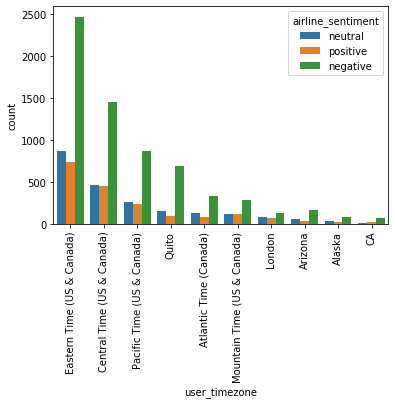

In [26]:
chart = sns.countplot(x ='user_timezone', hue='airline_sentiment', 
              data=df_1, order=df_1['user_timezone'].value_counts().iloc[:10].index)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90);

Looking at the top ten user_timezones we see that all of them have more negative sentiments then other sentiments with some by a lot.

In [27]:
# Create list of the non top ten inthe user_timezone 
user_timezone_lowest = list(df_1['user_timezone'].value_counts().tail(842).index)
# create a dummie matrix of user_timezone
df_ut = pd.get_dummies(df_1['user_timezone'])
# create other_timezone column and fill with zero
df_ut['other_timezone'] = 0
# combine non top ten user_timezone into other_timezone column
for c in user_timezone_lowest:
    df_ut['other_timezone'] = df_ut['other_timezone'] + df_ut[c]
    df_ut = df_ut.drop(c, axis=1)
# add tweet_id to dummies matrix and merge with original dataframe
df_ut['tweet_id'] = df_1['tweet_id']

df_1 = pd.merge(df_1, df_ut, on='tweet_id')

In [28]:
df_1 = df_1.drop('tweet_location', axis=1)

We will drop tweet_location because there aren't a lot of samples.

In [29]:
df_1['tweet_char_len'] = df_1['text'].str.len()

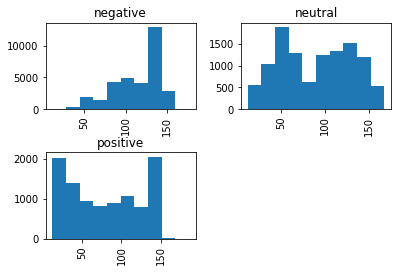

In [30]:
df_1.hist(column='tweet_char_len', by='airline_sentiment');

We can create a value with the tweet text charactor length and see if there is corrilation betwee tweet length and negative or positive sentiment.

Looking at the negative and other sentiment histograms we see that negative twee_char_len is skewed toards the right 

# Clean Text

In [42]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from string import punctuation 
from nltk.corpus import stopwords

from wordcloud import WordCloud, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn.model_selection import train_test_split

In [48]:
StopWords = list(set(stopwords.words('english'))) + list(punctuation) + ['AT_USER','URL']

def process_tweets(tweet):
    # convert text to lower-case
    tweet = tweet.lower()
    # remove URLs
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 
                   'URL', tweet)
    # remove usernames
    tweet = re.sub('@[^\s]+', 'AT_USER', tweet)
    # remove the # in #hashtag
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet) 
    # remove repeated characters
    tknzr = TweetTokenizer()
    tweet = tknzr.tokenize(tweet)
    # return word if not in stopwords
    w = []
    for word in tweet:
        if word not in StopWords:
            w.append(word)
    s = ' '
    s = s.join(w)
    return s

In [49]:
df_1['tweet_clean'] = df_1['text'].apply(process_tweets)

In [50]:
df_1['tweet_clean'].head(10)

0                                                 said
1          plus added commercials experience ... tacky
2           today ... must mean need take another trip
3    really aggressive blast obnoxious entertainmen...
4                                 really big bad thing
5    seriously would pay 30 flight seats playing re...
6    yes nearly every time fly vx “ ear worm ” ’ go...
7    really missed prime opportunity men without ha...
8                                           well … :-d
9                      amazing arrived hour early good
Name: tweet_clean, dtype: object

## Word Clouds

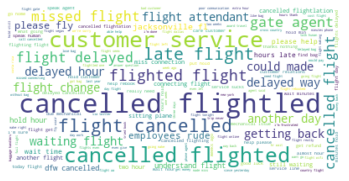

In [51]:
negative_text = " ".join(tweet for tweet in df_1['tweet_clean'][df_1['airline_sentiment'] == 'negative'])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords.words('english'), background_color="white").generate(negative_text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

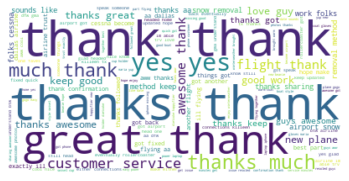

In [52]:
positive_text = " ".join(tweet for tweet in df_1['tweet_clean'][df_1['airline_sentiment'] == 'positive'])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords.words('english'), background_color="white").generate(positive_text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

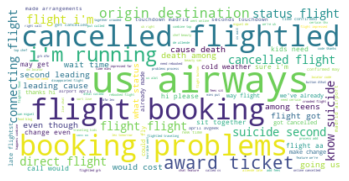

In [53]:
neutral_text = " ".join(tweet for tweet in df_1['tweet_clean'][df_1['airline_sentiment'] == 'neutral'])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords.words('english'), background_color="white").generate(neutral_text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Model Building

### Vectorizer

In [54]:
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
import time

In [55]:
df_2 = df_1.fillna('')

#Add the features of the dataframe that you want to transform and/or combine
mapper = DataFrameMapper([('American', None),
                          ('Delta', None),
                          ('Southwest', None),
                          ('US Airways', None),
                          ('United', None),
                          ('Virgin America', None),
                          ('Monday', None),
                          ('Tuesday', None),
                          ('Wednesday', None),
                          ('Thursday', None),
                          ('Friday', None),
                          ('Saturday', None),
                          ('Sunday', None),
                          ('Alaska', None),
                          ('Arizona', None),
                          ('Atlantic Time (Canada)', None),
                          ('CA', None),
                          ('Central Time (US & Canada)', None),
                          ('Eastern Time (US & Canada)', None),
                          ('London', None),
                          ('Mountain Time (US & Canada)', None),
                          ('Pacific Time (US & Canada)', None),
                          ('Quito', None),
                          ('other_timezone', None),
                          ('tweet_char_len', None),
                          # remove words that appear <0.5% of the samples
                          ('tweet_clean', TfidfVectorizer(min_df=15))
                         ])

features = mapper.fit_transform(df_2)

In [83]:
# remove words that appear <0.5% of the samples
tf=TfidfVectorizer(min_df=15)
text_tf= tf.fit_transform(df_1['tweet_clean'])
len(tf.get_feature_names())

1582

### Split into Train and Test

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [87]:
# Split the data between train and test
X_train, X_test, y_train, y_test = train_test_split(text_tf, df_2['airline_sentiment'],test_size=0.33, shuffle=True, random_state = 42)

# have the model be split into 10 folds
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

### Random Forest Classifier

In [85]:
from sklearn.ensemble import RandomForestClassifier as rfc

In [93]:
classifier = rfc(n_estimators=100)
classifier.fit(X_train,y_train)
classifier.score(X_test,y_test)

0.8873429084380611

In [89]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

In [95]:
t0 = time.time()

clf_rfc = rfc()

hyperparameters = {'n_estimators':stats.randint(10,300), 
                   'criterion':['gini','entropy'], 
                   'min_samples_split':stats.randint(2,9), 
                   'bootstrap':[True,False]
                  }

clf_randcv = RandomizedSearchCV(estimator=clf_rfc, 
                                param_distributions=hyperparameters, 
                                scoring='accuracy', 
                                cv=kfold, 
                                random_state=42, 
                                n_jobs=-1, 
                                n_iter=1000, 
                                return_train_score=True)

clf_randcv.fit(X_train, y_train)

t1 = time.time()
timeit=t1-t0
print(timeit)

93528.2764890194


In [100]:
training_score = clf_randcv.cv_results_['mean_train_score'][clf_randcv.best_index_]
training_std = clf_randcv.cv_results_['std_train_score'][clf_randcv.best_index_]
print("Training Score = {:.3f}".format(training_score)
        + " ({:.3f})".format(training_std))

validation_score = clf_randcv.best_score_
test_std = clf_randcv.cv_results_['std_test_score'][clf_randcv.best_index_]
print("Validation Score = {:.3f}".format(validation_score)
          + " ({:.3f})".format(test_std))

Training Score = 0.955 (0.000)
Validation Score = 0.891 (0.003)


In [99]:
clf_randcv.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'min_samples_split': 5,
 'n_estimators': 151}

In [116]:
clf_randcv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=151,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### SVC Classifier

In [101]:
# import the required module from scikit learn
from sklearn.svm import LinearSVC

In [118]:
t0 = time.time()

clf_svc = LinearSVC()

hyperparameters = {'C': [1, 11, 21, 31, 41, 51, 61, 71, 81, 91], 
                   'tol': [0.01, 0.0001, 1e-09]
                  }

clf_svc_gridcv = GridSearchCV(estimator=clf_svc, 
                              param_grid=hyperparameters, 
                              scoring='accuracy', 
                              cv=kfold, 
                              n_jobs=-1, 
                              return_train_score=True)

clf_svc_gridcv.fit(X_train, y_train)

t1 = time.time()
timeit=t1-t0
print(timeit)

1211.3810451030731


In [119]:
training_score = clf_svc_gridcv.cv_results_['mean_train_score'][clf_svc_gridcv.best_index_]
training_std = clf_svc_gridcv.cv_results_['std_train_score'][clf_svc_gridcv.best_index_]
print("Training Score = {:.3f}".format(training_score)
        + " ({:.3f})".format(training_std))

validation_score = clf_svc_gridcv.best_score_
test_std = clf_svc_gridcv.cv_results_['std_test_score'][clf_svc_gridcv.best_index_]
print("Validation Score = {:.3f}".format(validation_score)
          + " ({:.3f})".format(test_std))

Training Score = 0.920 (0.000)
Validation Score = 0.892 (0.003)


In [120]:
clf_svc_gridcv.best_params_

{'C': 1, 'tol': 0.01}

In [121]:
clf_svc_gridcv.best_estimator_

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.01,
          verbose=0)

### MultinomialNB Classifier

In [122]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [123]:
t0 = time.time()

clf_mnb = MultinomialNB()

hyperparameters = {'alpha': [0.001, 0.01, 0.1, 0, 10, 20, 30, 40, 50, 60, 70, 
                             80, 90, 100]}

clf_mnb_gridcv = GridSearchCV(estimator=clf_mnb, 
                              param_grid=hyperparameters, 
                              scoring='accuracy', 
                              cv=kfold, 
                              n_jobs=-1, 
                              return_train_score=True)

clf_mnb_gridcv.fit(X_train, y_train)

t1 = time.time()
timeit=t1-t0
print(timeit)

9.089990377426147


In [124]:
training_score = clf_mnb_gridcv.cv_results_['mean_train_score'][clf_mnb_gridcv.best_index_]
training_std = clf_mnb_gridcv.cv_results_['std_train_score'][clf_mnb_gridcv.best_index_]
print("Training Score = {:.3f}".format(training_score)
        + " ({:.3f})".format(training_std))

validation_score = clf_mnb_gridcv.best_score_
test_std = clf_mnb_gridcv.cv_results_['std_test_score'][clf_mnb_gridcv.best_index_]
print("Validation Score = {:.3f}".format(validation_score)
          + " ({:.3f})".format(test_std))

Training Score = 0.886 (0.000)
Validation Score = 0.877 (0.004)


In [125]:
clf_mnb_gridcv.best_params_

{'alpha': 0.01}

In [126]:
clf_mnb_gridcv.best_estimator_

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [117]:
# Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install sklearn_pandas